# Clustering vMagnus

In [21]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community
from itertools import combinations

df1 = pd.read_pickle("moviesDfv3.pkl")
df2 = pd.read_pickle("moviesDfv2.pkl")

frames = [df1, df2]
moviesDf = pd.concat(frames)

In [22]:
actor_column = list(moviesDf["Actors"].to_numpy())
G = nx.Graph()

# Creating the graph. 
# adding edge between all actors in a given movie
for movie_cast in actor_column:
    G.add_nodes_from(movie_cast)
    pairs = list(combinations(movie_cast,2))
    G.add_edges_from(pairs)

In [23]:
# Extracting largest connected component
nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(nodes).copy()

print(f'Stats before removing weakly connected nodes')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}\n')

# Removing nodes with very small degree
remove = [node for node,degree in dict(G.degree()).items() if degree < 10]
G.remove_nodes_from(remove)
      
print(f'Stats after removing weakly connected nodes')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')

Stats before removing weakly connected nodes
Nodes: 11458
Edges: 81065

Stats after removing weakly connected nodes
Nodes: 3260
Edges: 30653


In [24]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.08it/s]

BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  7.59  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


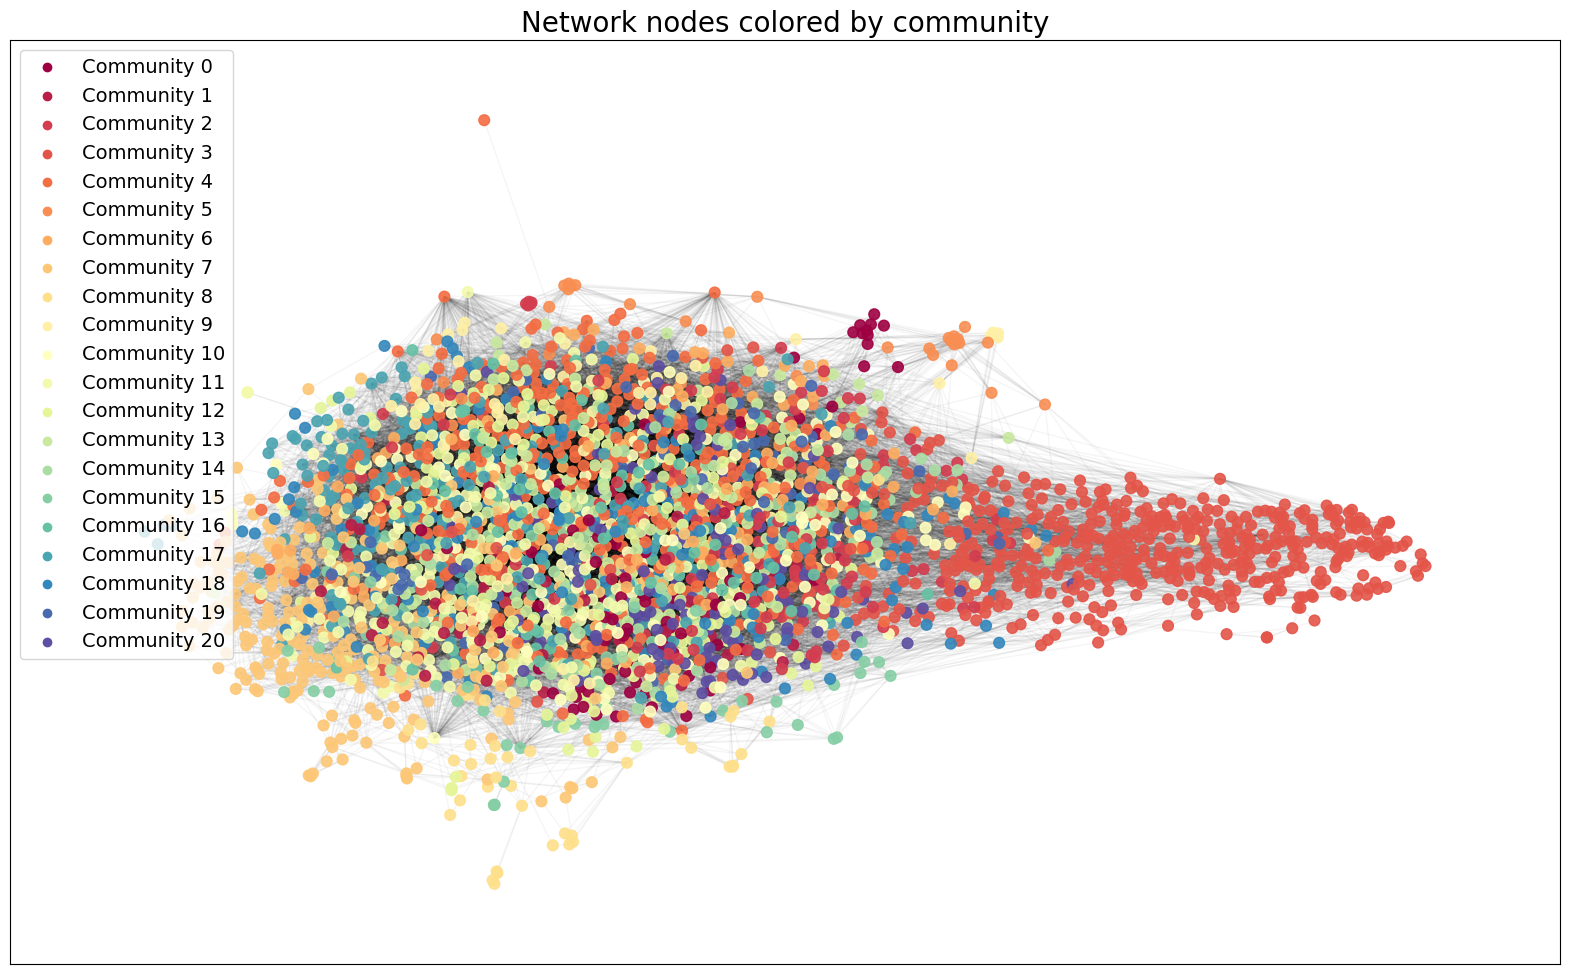

In [25]:
# Best partition found with louvain algorithm
partition = community.best_partition(G, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(G, pos = positions, node_color=node_color, alpha=0.9, node_size = 60);
nx.draw_networkx_edges(G, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.show()

In [26]:
# rearanging found partition
parts = []
for i in range(0, len(set(partition.values()))):
    parts.append([])
    
for actor, com in partition.items():
    parts[com].append(actor)

#sorting based on biggest communities
parts.sort(key=len, reverse = True)

In [27]:
# Most connected actors
sorted(G.degree, key=lambda x: x[1], reverse=True)

[('Robert De Niro', 131),
 ('Demi Moore', 115),
 ('Gene Hackman', 112),
 ('Christopher Walken', 109),
 ('Bruce Willis', 97),
 ('Jeff Goldblum', 97),
 ('Joan Cusack', 96),
 ('Danny DeVito', 95),
 ('Sean Connery', 94),
 ('Robert Duvall', 89),
 ('Meg Ryan', 87),
 ('Steve Buscemi', 86),
 ('Dan Hedaya', 82),
 ('Keanu Reeves', 82),
 ('Steve Martin', 81),
 ('Julianne Moore', 81),
 ('Harry Dean Stanton', 80),
 ('Wesley Snipes', 80),
 ('Andy Garcia', 79),
 ('Harvey Keitel', 79),
 ('Woody Harrelson', 79),
 ('Harrison Ford', 78),
 ('Jeff Daniels', 78),
 ('Christian Slater', 78),
 ('Juliette Lewis', 78),
 ('James Earl Jones', 78),
 ('Kevin Costner', 77),
 ('Kevin Pollak', 77),
 ('Christopher Lloyd', 76),
 ('Dan Aykroyd', 76),
 ('John Cusack', 75),
 ('Anthony Hopkins', 75),
 ('Jack Lemmon', 75),
 ('Christopher McDonald', 74),
 ('Denis Leary', 74),
 ('Johnny Depp', 74),
 ('Ed Harris', 73),
 ('Anne Bancroft', 73),
 ('Sandra Bullock', 73),
 ('Donald Sutherland', 72),
 ('Carol Kane', 70),
 ('Robin Will

In [29]:
# Checking actors with degrees in given partition
G.degree(parts[0])

DegreeView({'Maurice Evans': 17, 'Carl Reiner': 12, 'Barbara Stanwyck': 18, 'Ray Milland': 20, 'Ava Gardner': 11, 'Burt Lancaster': 42, 'Humphrey Bogart': 28, 'Cary Grant': 58, 'George Furth': 14, 'Dee Wallace': 26, 'Christopher Stone': 10, 'Ed Lauter': 39, 'Ingrid Bergman': 17, 'Elizabeth Taylor': 17, 'Rex Harrison': 14, 'Anthony Newley': 6, 'Peter Bull': 18, 'Stella Stevens': 10, 'Kathleen Freeman': 15, 'Norman Alden': 8, 'Howard Morris': 17, 'Elvia Allman': 9, 'Debbie Reynolds': 7, 'Paul Lynde': 12, 'Henry Gibson': 14, 'Martha Scott': 8, 'Agnes Moorehead': 16, 'Hermione Baddeley': 24, 'John Carradine': 14, 'Hal Smith': 12, 'James Stewart': 41, 'Martin Balsam': 28, 'Tim Conway': 28, 'Kevin Zegers': 9, 'Cynthia Stevenson': 37, 'Gregory Harrison': 11, 'Nora Dunn': 19, 'Robert Costanzo': 16, 'Patrick Macnee': 21, 'Farley Granger': 8, 'Edith Evanson': 10, 'Cedric Hardwicke': 11, 'Constance Collier': 11, 'Alfred Hitchcock': 8, 'Karen Black': 34, 'William Devane': 12, 'Cathleen Nesbitt': 1